In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset.csv");
data.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1.609460e+12,28923.63,28961.66,28913.12,28961.66,27.457032,1.609460e+12,7.943820e+05,1292,16.777195,485390.8268
1,1.609460e+12,28961.67,29017.50,28961.01,29009.91,58.477501,1.609460e+12,1.695803e+06,1651,33.733818,978176.4682
2,1.609460e+12,29009.54,29016.71,28973.58,28989.30,42.470329,1.609460e+12,1.231359e+06,986,13.247444,384076.8545
3,1.609460e+12,28989.68,28999.85,28972.33,28982.69,30.360677,1.609460e+12,8.800168e+05,959,9.456028,274083.0751
4,1.609460e+12,28982.67,28995.93,28971.80,28975.65,24.124339,1.609460e+12,6.992262e+05,726,6.814644,197519.3749


In [ ]:
# Convert "Open Time" to datetime format
data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')

In [ ]:

# Select relevant columns
data = data[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [ ]:
data.head()

,Open Time,Open,High,Low,Close,Volume
0,2021-01-01 00:13:20,28923.63,28961.66,28913.12,28961.66,27.457032
1,2021-01-01 00:13:20,28961.67,29017.50,28961.01,29009.91,58.477501
2,2021-01-01 00:13:20,29009.54,29016.71,28973.58,28989.30,42.470329
3,2021-01-01 00:13:20,28989.68,28999.85,28972.33,28982.69,30.360677
4,2021-01-01 00:13:20,28982.67,28995.93,28971.80,28975.65,24.124339


In [ ]:
print(data.isnull().sum())  # Check if there are missing values

Open Time    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


In [ ]:
# Handle missing values
data.fillna(method='ffill', inplace=True)

<ipython-input-76-4ffc19450609>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
# Feature Engineering
data['Rolling Mean'] = data['Close'].rolling(window=5).mean()
data['Relative Change'] = (data['Close'] - data['Open']) / data['Open']
data.dropna(inplace=True)  # Drop NaN values after rolling mean calculation

In [ ]:
# Convert "Open Time" to a numeric timestamp for ML models
data['Timestamp'] = data['Open Time'].astype('int64') // 10**9  # Convert datetime to UNIX timestamp

In [ ]:
# Drop "Open Time" (not useful for ML directly)
data.drop(columns=['Open Time'], inplace=True)

In [ ]:
data.head()

,Open,High,Low,Close,Volume,Rolling Mean,Relative Change,Timestamp
4,28982.67,28995.93,28971.80,28975.65,24.124339,28983.842,-0.000242,1609460000
5,28975.65,28979.53,28933.16,28937.11,22.396014,28978.932,-0.001330,1609460000
6,28937.11,28963.25,28937.10,28943.87,20.480294,28965.724,0.000234,1609460000
7,28943.88,28954.48,28930.00,28934.84,20.962343,28954.832,-0.000312,1609460000
8,28934.84,28936.15,28889.24,28900.00,52.645478,28938.294,-0.001204,1609460000


In [ ]:
# Feature Scaling
numeric_features = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Rolling Mean', 'Relative Change']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[numeric_features])
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features)

In [ ]:
X = scaled_df[['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Rolling Mean', 'Relative Change']]
y = data['Close']

Data Summary:
       Open      High       Low     Close     Volume  Rolling Mean  \
4  28982.67  28995.93  28971.80  28975.65  24.124339     28983.842   
5  28975.65  28979.53  28933.16  28937.11  22.396014     28978.932   
6  28937.11  28963.25  28937.10  28943.87  20.480294     28965.724   
7  28943.88  28954.48  28930.00  28934.84  20.962343     28954.832   
8  28934.84  28936.15  28889.24  28900.00  52.645478     28938.294   

   Relative Change   Timestamp  
4        -0.000242  1609460000  
5        -0.001330  1609460000  
6         0.000234  1609460000  
7        -0.000312  1609460000  
8        -0.001204  1609460000  

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 188313 entries, 4 to 188316
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Open             188313 non-null  float64
 1   High             188313 non-null  float64
 2   Low              188313 non-null  float64
 3   Close     

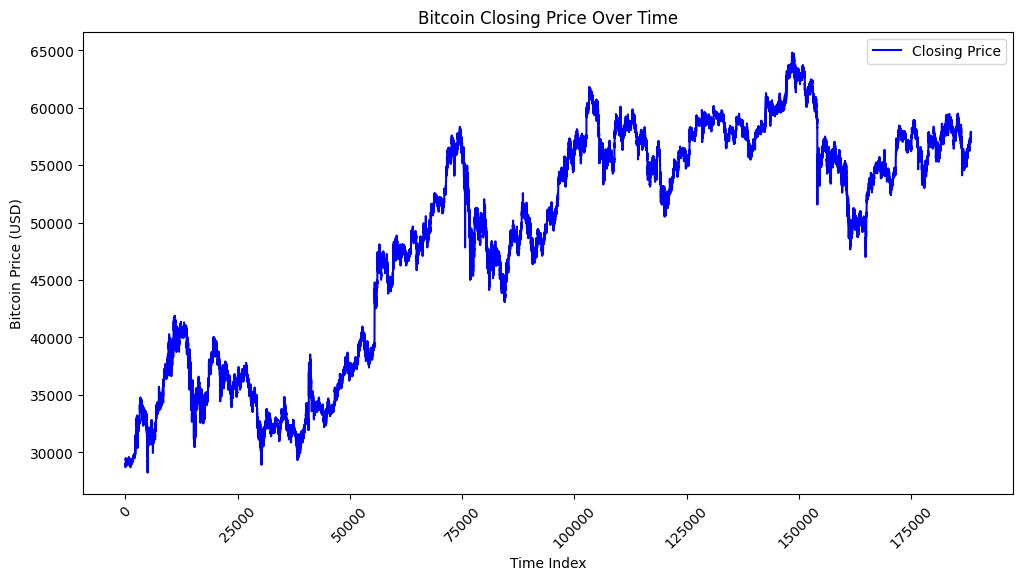

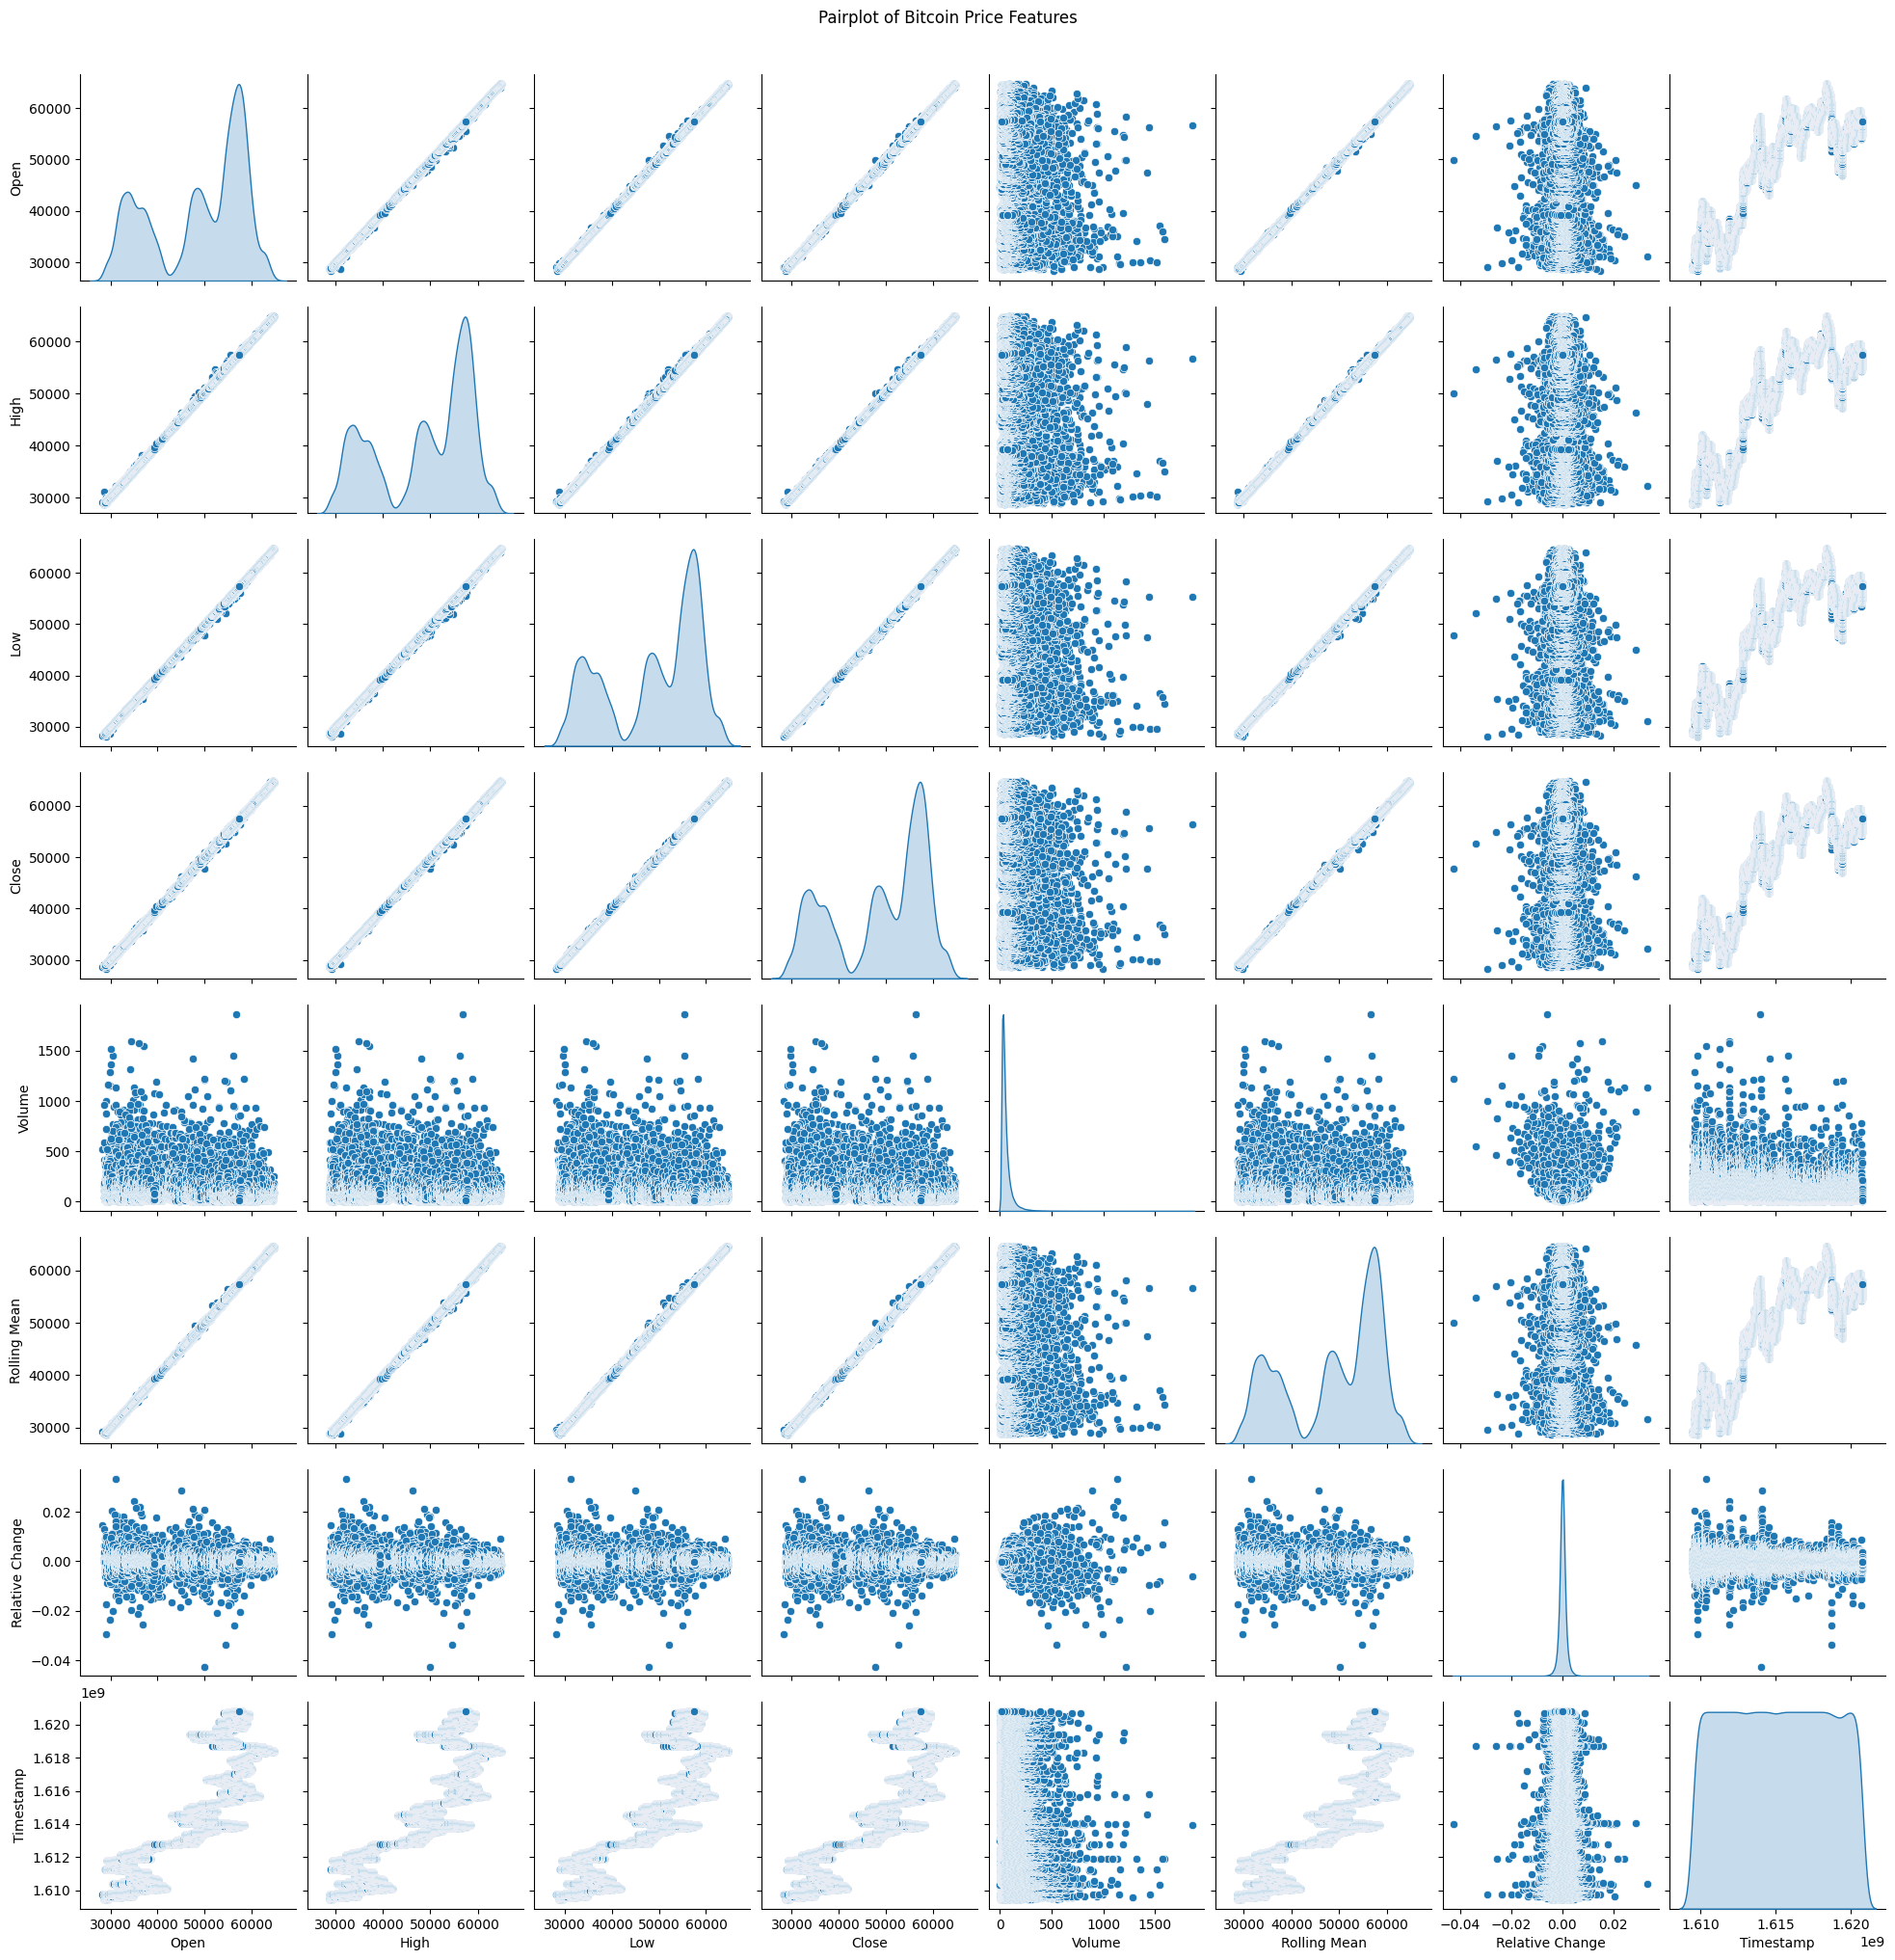

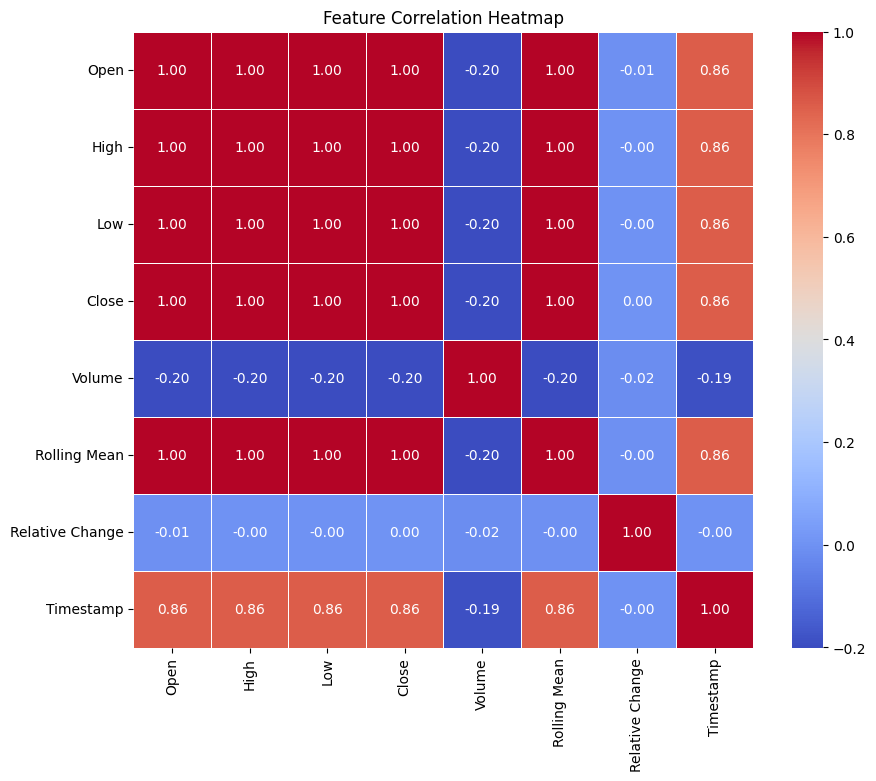

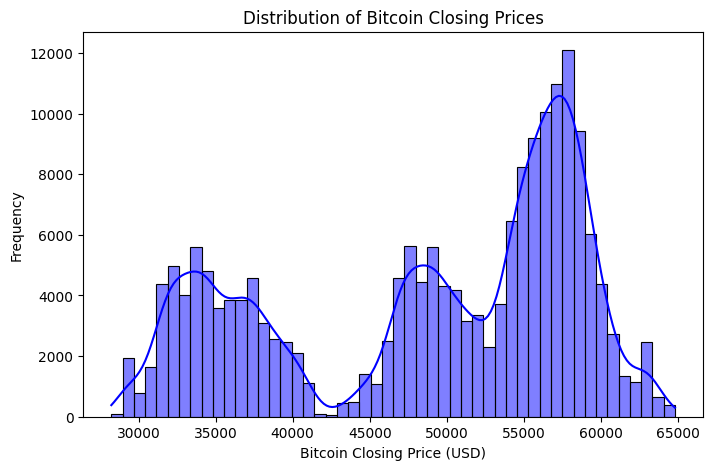

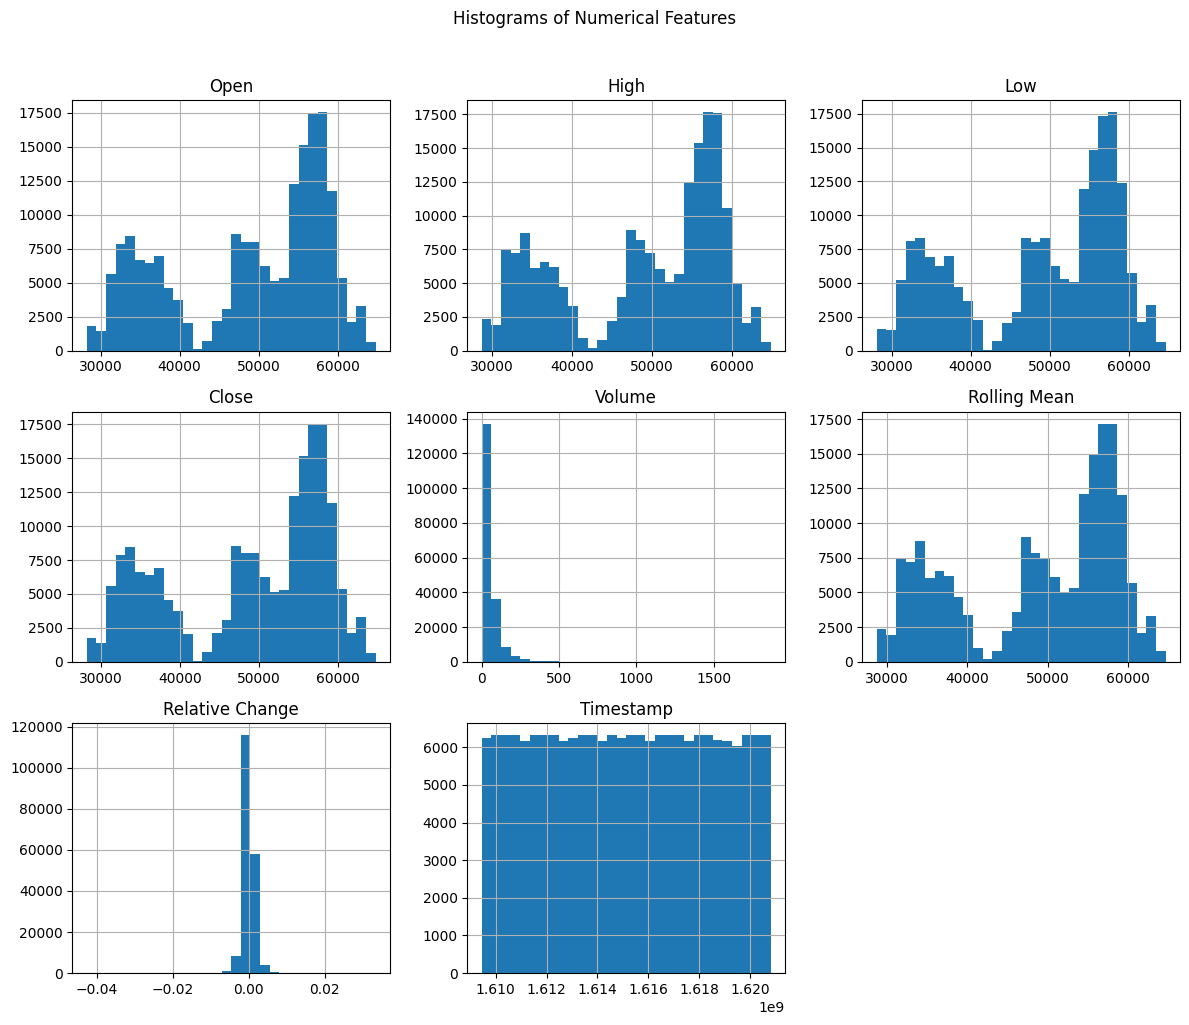

In [ ]:
# 1. Data Summary
print("Data Summary:")
print(data.head())
print("\nData Info:")
print(data.info())
print("\nData Statistics:")
print(data.describe())

# 2. Time-Series Visualization of Bitcoin Prices
plt.figure(figsize=(12,6))
sns.lineplot(x=data.index, y=data['Close'], label="Closing Price", color='blue')
plt.xlabel("Time Index")
plt.ylabel("Bitcoin Price (USD)")
plt.title("Bitcoin Closing Price Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.savefig("Bitcoin_Price_Trend.png", dpi=300, bbox_inches="tight")
plt.show()

# 3. Pairplot for visualizing relationships between features
sns.pairplot(data, diag_kind='kde')
plt.suptitle("Pairplot of Bitcoin Price Features", y=1.02)
plt.savefig("Pairplot_Features.png", dpi=300, bbox_inches="tight")
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.savefig("Correlation_Heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

# 5. Distribution of the target variable (Closing Price)
plt.figure(figsize=(8, 5))
sns.histplot(data['Close'], bins=50, kde=True, color='blue')
plt.xlabel("Bitcoin Closing Price (USD)")
plt.ylabel("Frequency")
plt.title("Distribution of Bitcoin Closing Prices")
plt.savefig("Bitcoin_Price_Distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# 5. Histograms of numerical features
data.hist(figsize=(12, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", y=1.02)
plt.tight_layout()
plt.savefig("Histograms_Numerical_Features.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Model Definitions
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42)),
    ('Support Vector Regressor', SVR(kernel='rbf')),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('XGBoost Regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
]

In [ ]:
# Helper Function for Metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, rmse, r2, mape


In [ ]:
# Evaluate Models
evaluation_results = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, r2, mape = calculate_metrics(y_test, y_pred)
    evaluation_results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

In [ ]:
# Convert Results to DataFrame
results_df = pd.DataFrame(evaluation_results).T
results_df.sort_values(by='R2', ascending=False, inplace=True)

In [ ]:
# Save Results to CSV
results_df.to_csv('model_comparison_results.csv', index=True)

In [ ]:
results_df.head(10)

,MAE,RMSE,R2,MAPE
Linear Regression,8.971862,12.893440,0.999998,0.000198
Random Forest Regressor,10.120249,18.261925,0.999997,0.000222
Decision Tree Regressor,14.503921,25.427822,0.999993,0.000317
XGBoost Regressor,29.114418,48.101432,0.999976,0.000644
K-Nearest Neighbors,29.972202,50.579918,0.999974,0.000664
Gradient Boosting Regressor,53.258880,71.571486,0.999947,0.001139
Support Vector Regressor,461.673121,888.537803,0.991880,0.011191


<ipython-input-107-8e0d9f81f4d8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['R2'], palette='Blues')


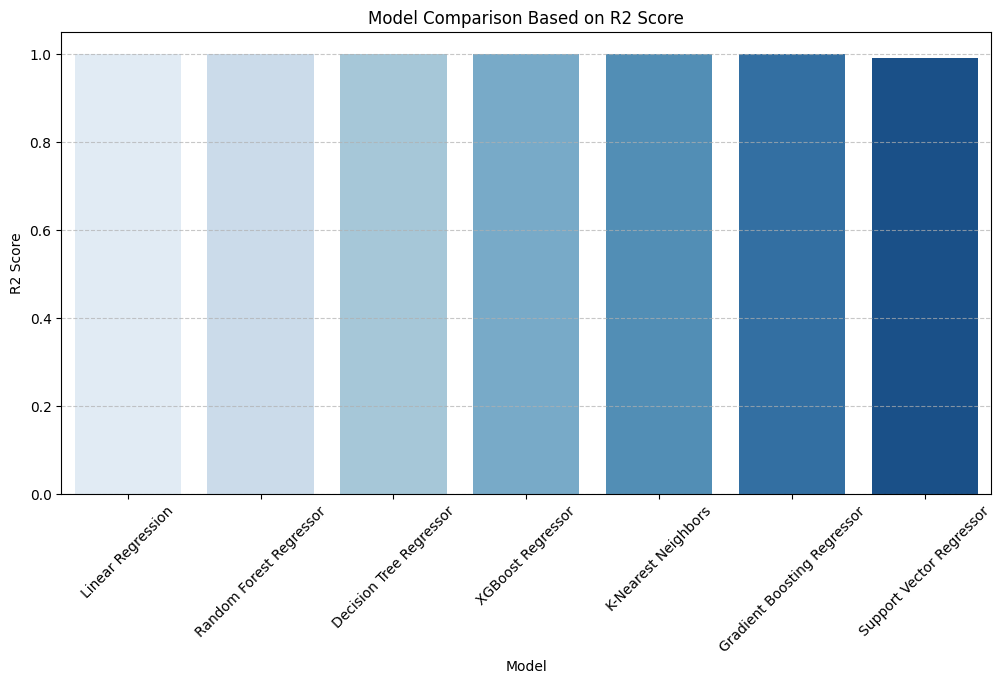

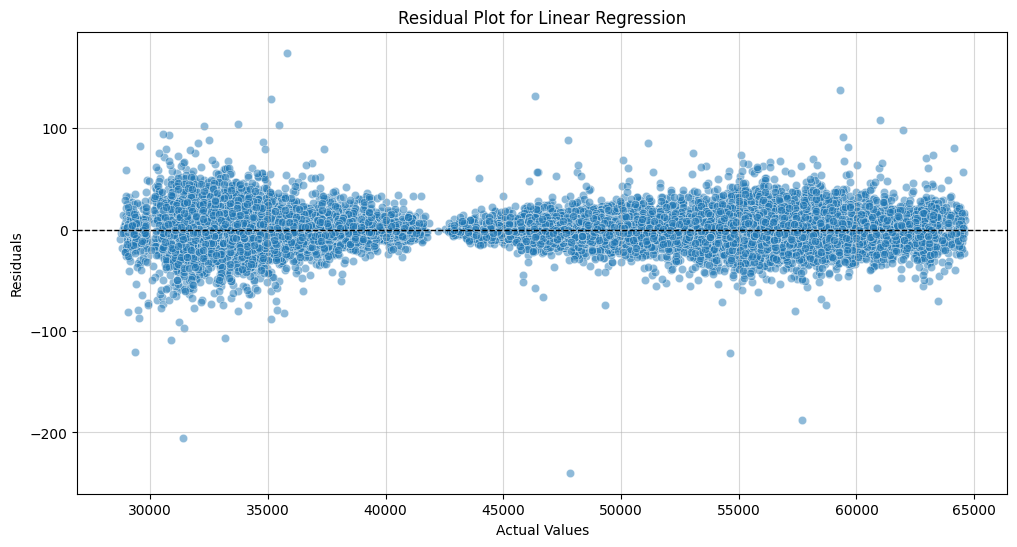

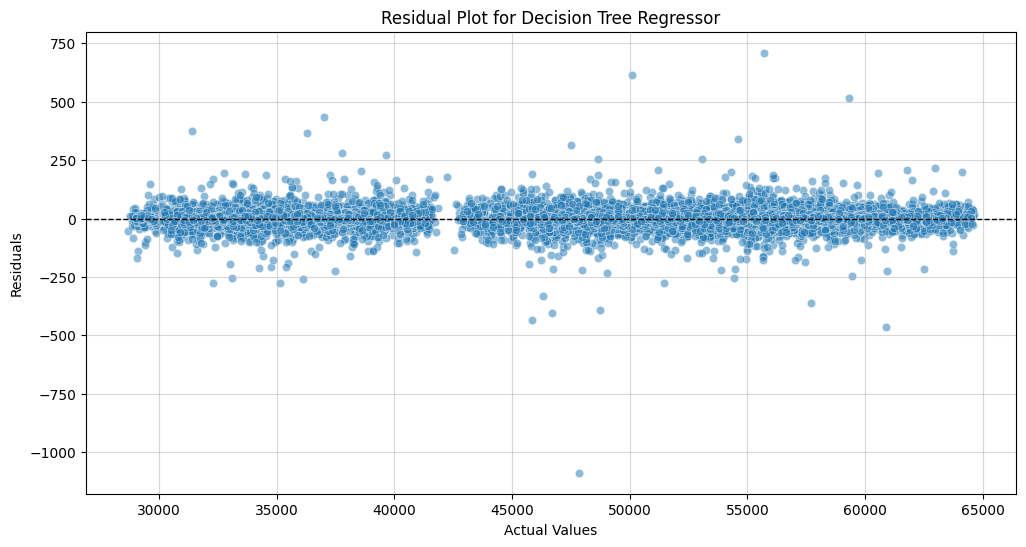

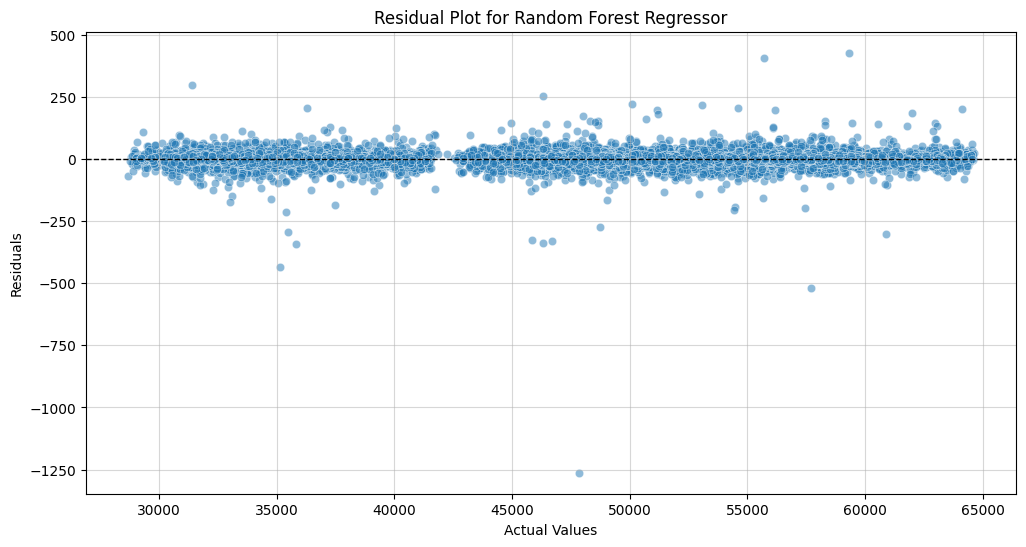

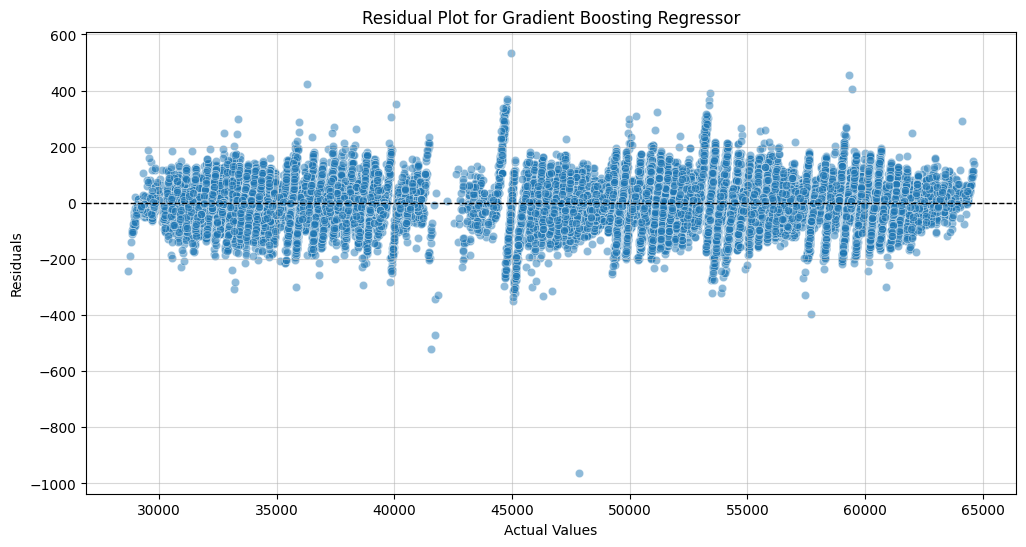

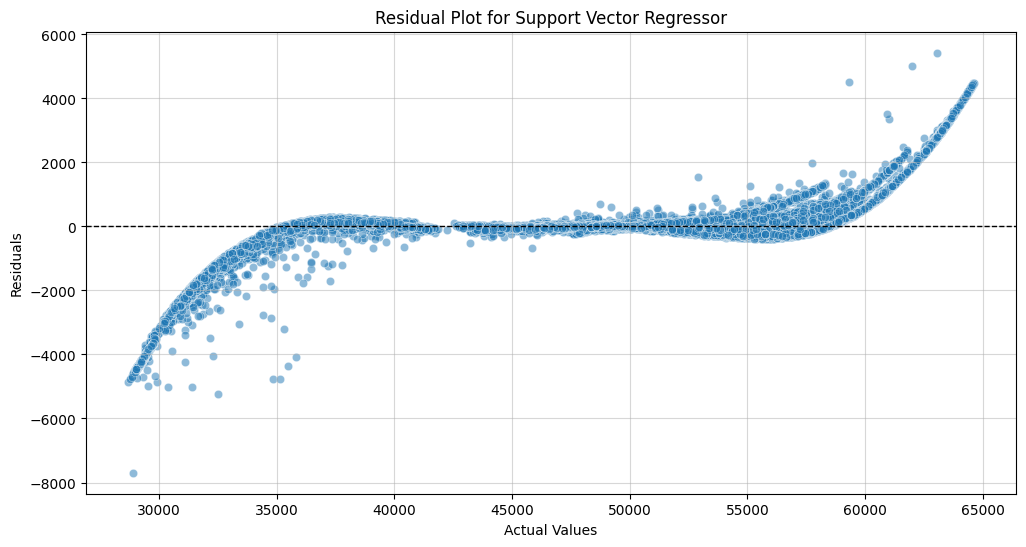

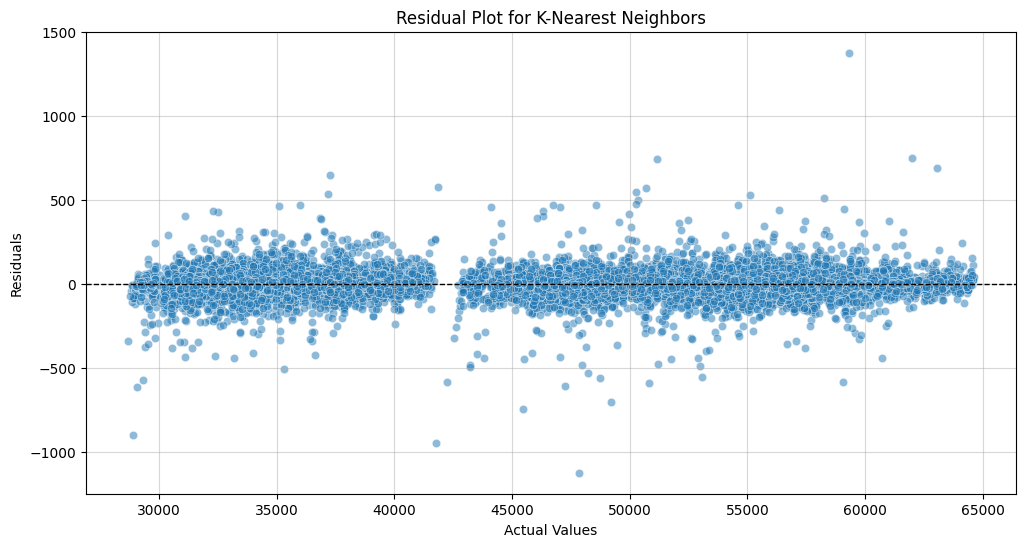

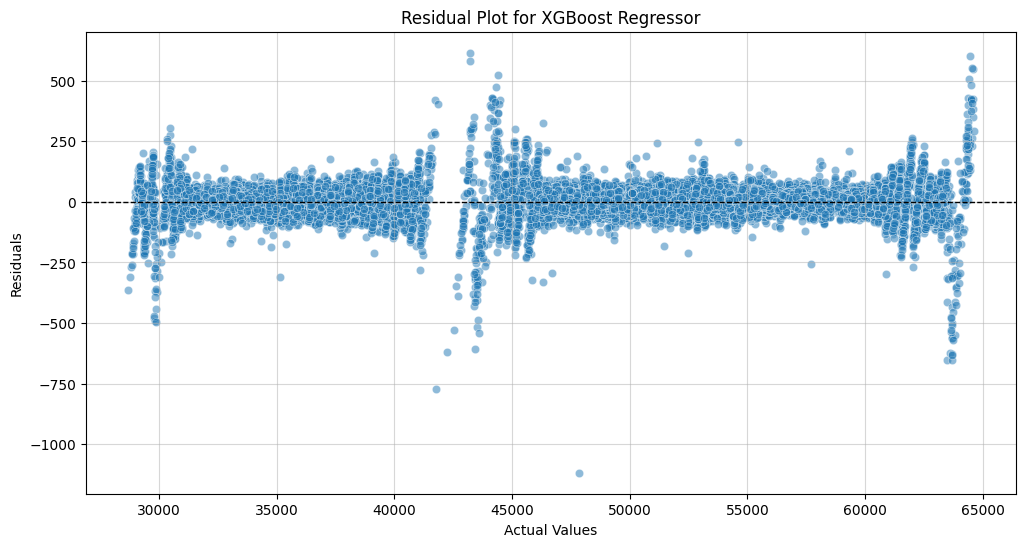

Model evaluation results saved to 'model_comparison_results.csv'.


In [ ]:
 # Visualization of Model Performance
 plt.figure(figsize=(12, 6))
 sns.barplot(x=results_df.index, y=results_df['R2'], palette='Blues')
 plt.title('Model Comparison Based on R2 Score')
 plt.ylabel('R2 Score')
 plt.xlabel('Model')
 plt.xticks(rotation=45)
 plt.grid(axis='y', linestyle='--', alpha=0.7)
 plt.savefig("ModelComparison.png", dpi=300, bbox_inches="tight")
 plt.show()

 # Residual Plots for Each Model
 for name, model in models:
     y_pred = model.predict(X_test)
     residuals = y_test - y_pred
     plt.figure(figsize=(12, 6))
     sns.scatterplot(x=y_test, y=residuals, alpha=0.5)
     plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
     plt.title(f'Residual Plot for {name}')
     plt.xlabel('Actual Values')
     plt.ylabel('Residuals')
     plt.grid(alpha=0.5)
     plt.savefig(f"ResidualPlot_{name.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
     plt.show()

 print("Model evaluation results saved to 'model_comparison_results.csv'.")